In [2]:
import torch
from os import path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import h5py
import numpy as np
import wget
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim


/home/sulaimon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
classes = ('cloudy', 'rain', 'shine', 'sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
    filename = f'WeatherClassificationDB_{fname}.mat'
    if not path.exists(filename):
        print(f'Downloading: {filename}')
        wget.download(data_path + filename, filename)
    else:
        print(f'{filename} already exists.')
    flist.append(filename)

# Load dataset
def load_mat_data(filename):
    with h5py.File(filename, 'r') as f:
        return np.array(f['images']['input']).astype(np.float32) / 255.0

cloudy_imgs = load_mat_data(flist[0])
rain_imgs = load_mat_data(flist[1])
shine_imgs = load_mat_data(flist[2])
sunrise_imgs = load_mat_data(flist[3])

InputImages = np.concatenate((cloudy_imgs, rain_imgs, shine_imgs, sunrise_imgs), axis=0)


WeatherClassificationDB_cloudy.mat already exists.
WeatherClassificationDB_rain.mat already exists.
WeatherClassificationDB_shine.mat already exists.
WeatherClassificationDB_sunrise.mat already exists.


In [ ]:
def add_gaussian_noise(images, mean=0, stddev=0.1):
    noise = torch.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)  # Clip values between [0,1]

# Convert to torch tensors
##InputImages = torch.tensor(InputImages).permute(0, 3, 1, 2)  # Convert to NCHW format
InputImages = torch.tensor(InputImages, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW format
noisy_imgs = add_gaussian_noise(InputImages)



print(cloudy_imgs.shape) # (NHWC)
print(rain_imgs.shape) # (NHWC)
print(shine_imgs.shape) # (NHWC)
print(sunrise_imgs.shape) # (NHWC)

InputImages.shape #Should be in NCHW now

(207, 256, 256, 3)
(215, 256, 256, 3)
(253, 256, 256, 3)
(357, 256, 256, 3)


torch.Size([1032, 3, 256, 256])

In [26]:
class WeatherDataset(Dataset):
    def __init__(self, noisy, clean):
        self.noisy = noisy
        self.clean = clean

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx]

# Split dataset: 70% train, 10% validation, 20% test
dataset = WeatherDataset(noisy_imgs, InputImages)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)


## Verify the train, test, and validation sample
def print_dataset_shapes(loader, name):
    data_iter = iter(loader)
    noisy_sample, clean_sample = next(data_iter)  # Get one batch
    print(f"{name} set: Noisy shape: {noisy_sample.shape}, Clean shape: {clean_sample.shape}")

# Print dataset shapes
print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")

# Also print dataset sizes
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Train set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Validation set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Test set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Train set size: 722
Validation set size: 103
Test set size: 207


In [27]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, Nc=64):
        super(UNet, self).__init__()

        # Contracting Path
        self.conv1 = self.conv_block(input_channels, Nc)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = self.conv_block(Nc, Nc * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = self.conv_block(Nc * 2, Nc * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = self.conv_block(Nc * 4, Nc * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = self.conv_block(Nc * 8, Nc * 16)

        # Expanding Path
        self.upconv6 = nn.ConvTranspose2d(Nc * 16, Nc * 8, kernel_size=2, stride=2)
        self.conv6 = self.conv_block(Nc * 16, Nc * 8)

        self.upconv7 = nn.ConvTranspose2d(Nc * 8, Nc * 4, kernel_size=2, stride=2)
        self.conv7 = self.conv_block(Nc * 8, Nc * 4)

        self.upconv8 = nn.ConvTranspose2d(Nc * 4, Nc * 2, kernel_size=2, stride=2)
        self.conv8 = self.conv_block(Nc * 4, Nc * 2)

        self.upconv9 = nn.ConvTranspose2d(Nc * 2, Nc, kernel_size=2, stride=2)
        self.conv9 = self.conv_block(Nc * 2, Nc)

        self.final_conv = nn.Conv2d(Nc, 3, kernel_size=1)
        self.final_merge_conv = nn.Conv2d(6, 3, kernel_size=1)  # Merging input and output

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.conv5(pool4)

        # Expanding Path
        up6 = self.upconv6(conv5)
        merge6 = torch.cat((conv4, up6), dim=1)
        conv6 = self.conv6(merge6)

        up7 = self.upconv7(conv6)
        merge7 = torch.cat((conv3, up7), dim=1)
        conv7 = self.conv7(merge7)

        up8 = self.upconv8(conv7)
        merge8 = torch.cat((conv2, up8), dim=1)
        conv8 = self.conv8(merge8)

        up9 = self.upconv9(conv8)
        merge9 = torch.cat((conv1, up9), dim=1)
        conv9 = self.conv9(merge9)

        output = self.final_conv(conv9)
        merge10 = torch.cat((x, output), dim=1)
        final_output = self.final_merge_conv(merge10)

        return torch.sigmoid(final_output)

# Example usage
model = UNet(input_channels=3, Nc=64)

In [28]:
def psnr_metric(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true)
    return 10 * torch.log10(1 / mse)

def ssim_metric(y_true, y_pred):
    return torch.tensor(ssim(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), data_range=1.0))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()


In [9]:
# for i in range(torch.cuda.device_count()):
#     props = torch.cuda.get_device_properties(i)
#     print(f"GPU {i}: {props.name}")
#     print(f"Total Memory: {props.total_memory / 1024**3:.2f} GB")
#     print(f"Multiprocessors: {props.multi_processor_count}")
#     print(f"Max Threads per Block: {props.max_threads_per_block}")

In [37]:

def train_model(model, train_loader, val_loader, epochs=100, save_path="best_model.pth"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    

    model.to(device)  # Move model to GPU if available
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.MSELoss()

    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(noisy)
            loss = loss_fn(outputs, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU
                
                outputs = model(noisy)
                loss = loss_fn(outputs, clean)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with validation loss {best_loss:.4f}")

# Call the function
train_model(model, train_loader, val_loader)


Using device: cuda
Epoch 1, Train Loss: 0.0293, Val Loss: 0.0139
Model saved at epoch 1 with validation loss 0.0139
Epoch 2, Train Loss: 0.0073, Val Loss: 0.0036
Model saved at epoch 2 with validation loss 0.0036
Epoch 3, Train Loss: 0.0040, Val Loss: 0.0028
Model saved at epoch 3 with validation loss 0.0028
Epoch 4, Train Loss: 0.0036, Val Loss: 0.0026
Model saved at epoch 4 with validation loss 0.0026
Epoch 5, Train Loss: 0.0028, Val Loss: 0.0024
Model saved at epoch 5 with validation loss 0.0024
Epoch 6, Train Loss: 0.0038, Val Loss: 0.0028
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0018
Model saved at epoch 7 with validation loss 0.0018
Epoch 8, Train Loss: 0.0028, Val Loss: 0.0019
Epoch 9, Train Loss: 0.0026, Val Loss: 0.0023
Epoch 10, Train Loss: 0.0022, Val Loss: 0.0016
Model saved at epoch 10 with validation loss 0.0016
Epoch 11, Train Loss: 0.0028, Val Loss: 0.0019
Epoch 12, Train Loss: 0.0022, Val Loss: 0.0013
Model saved at epoch 12 with validation loss 0.0013
Epoch 13, Train 

In [38]:
def test_model(model, test_loader, device="cpu"):
    model.eval()
    model.to(device)
    total_psnr = 0
    total_ssim = 0
    num_samples = 0
    
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)
            
            for i in range(noisy.shape[0]):
                y_true = clean[i].permute(1, 2, 0).cpu().numpy()
                y_pred = outputs[i].permute(1, 2, 0).cpu().numpy()
                
                total_psnr += psnr(y_true, y_pred, data_range=1.0)
                total_ssim += ssim(y_true, y_pred, multichannel=True, data_range=1.0, win_size=3)

                num_samples += 1
    
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model(model, test_loader, device)


Average PSNR: 30.50 dB
Average SSIM: 0.8786


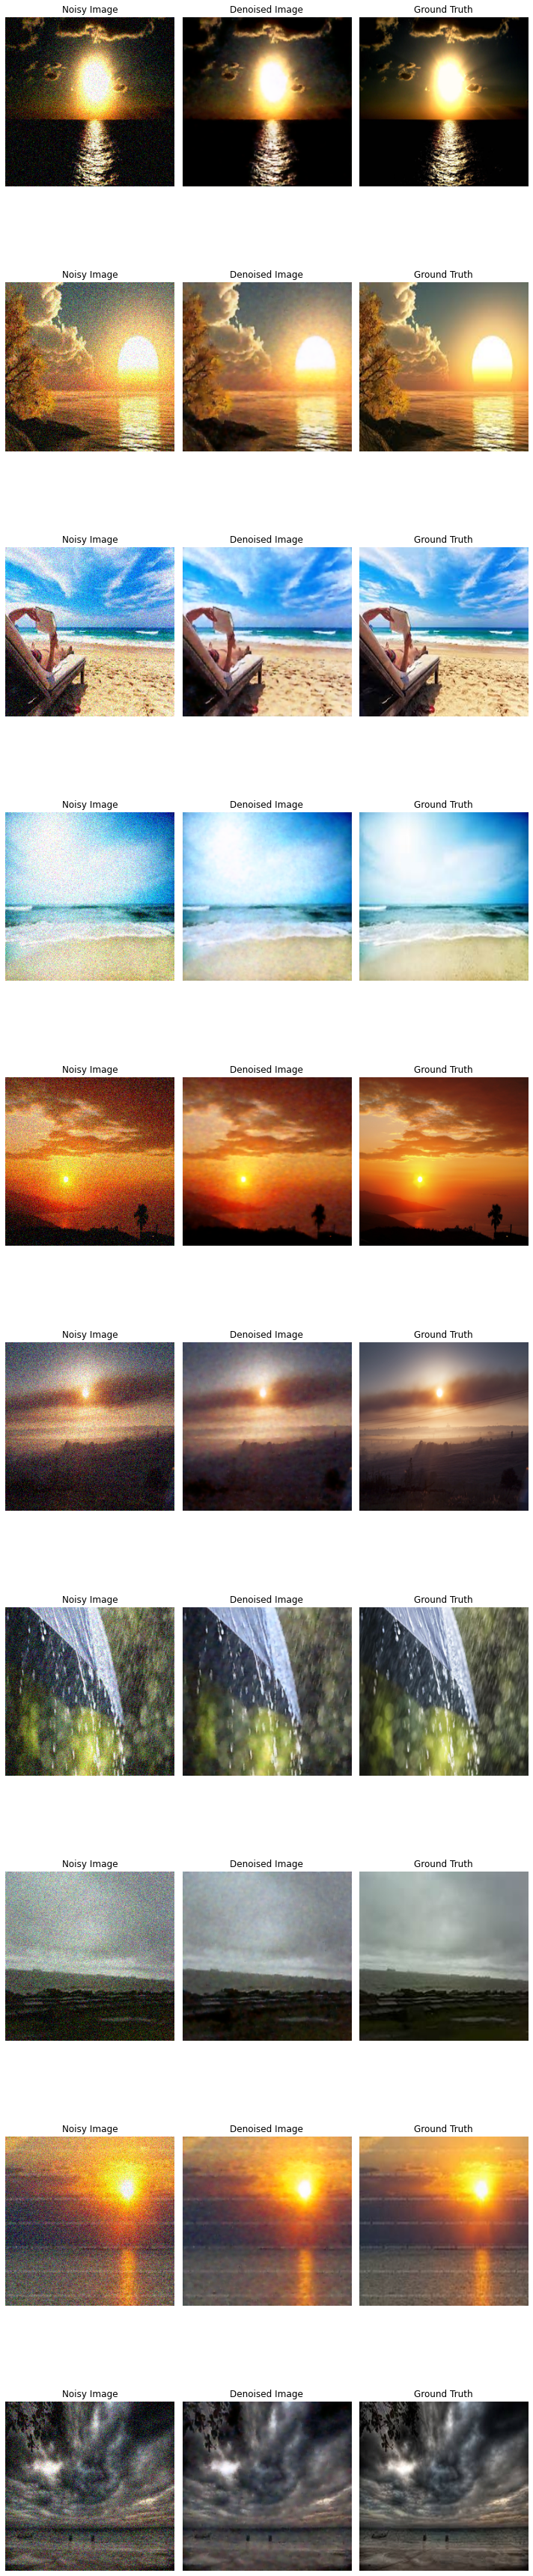

In [43]:
def visualize_results(model, test_loader, device, num_samples=10):
    model.eval()
    model.to(device)
    
    data_iter = iter(test_loader)
    noisy, clean = next(data_iter)
    noisy, clean = noisy.to(device), clean.to(device)
    
    with torch.no_grad():
        outputs = model(noisy)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(noisy[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(clean[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_results(model, test_loader, device)
